In [1]:
from os.path import isfile

import matplotlib.pyplot as plt
import numpy as np
from pylbm import lbm
from scipy.optimize import curve_fit

import m3


In [10]:
epochs = 3000
eps = 0.1
omegas = np.arange(0.1, 1.91, 0.2).round(decimals=1)
x_dim, y_dim = 30, 30

font_size = 20
plt.rc('font', size=16) 
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)

### Choose an initial distribution of  $ρ(r,t)$  and  $u(r,t)$  at  $t=0$  such as  $ρ(r,0)=ρ_0+ε \sin(2πx / L_x)$  and  $u(r,0)=0$ . Where  $L_x$  is the length of the domain in the  $x$  direction. Observe what happens with the 2D density distribution in time.

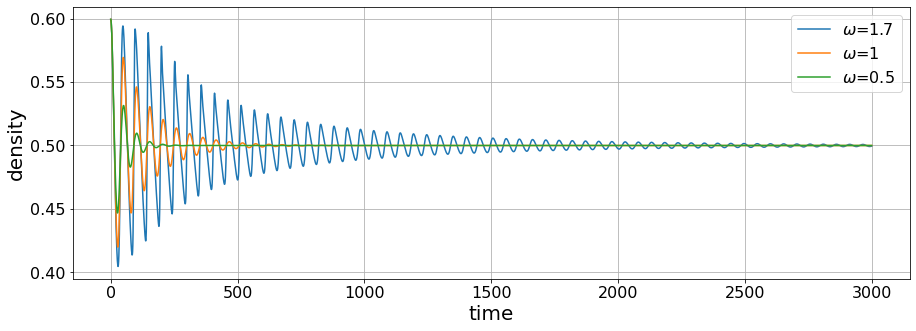

In [11]:
path = './m3-1.npy'
if not isfile(path):
    m3.m3_1()
densities_oms = np.load(path)
oms = [1.7,1,0.5]
fig, ax = plt.subplots(figsize=(15,5))
for o, densities in zip(oms, densities_oms):
    ax.plot(np.arange(epochs),densities, label='$\omega$='+str(o))
ax.set_xlabel("time")
ax.set_ylabel("density")
# ax.set_title("Density decay, omega=0.5")
ax.grid(True)
ax.legend()
lbm.save_fig(fig, 'm3-1-density-decay.pgf')
plt.show()
plt.close()

### M3.2 Choose an initial distribution of  $ρ(r,0)=1$  and  $u_x(r,0)=ε\sin(2πy / L_y)$ , i.e. a sinusoidal variation of the velocities  $u_x$  with the position  $y$ . Observe in both cases what happens dynamically as well as in the long time limit  $t→∞$ .

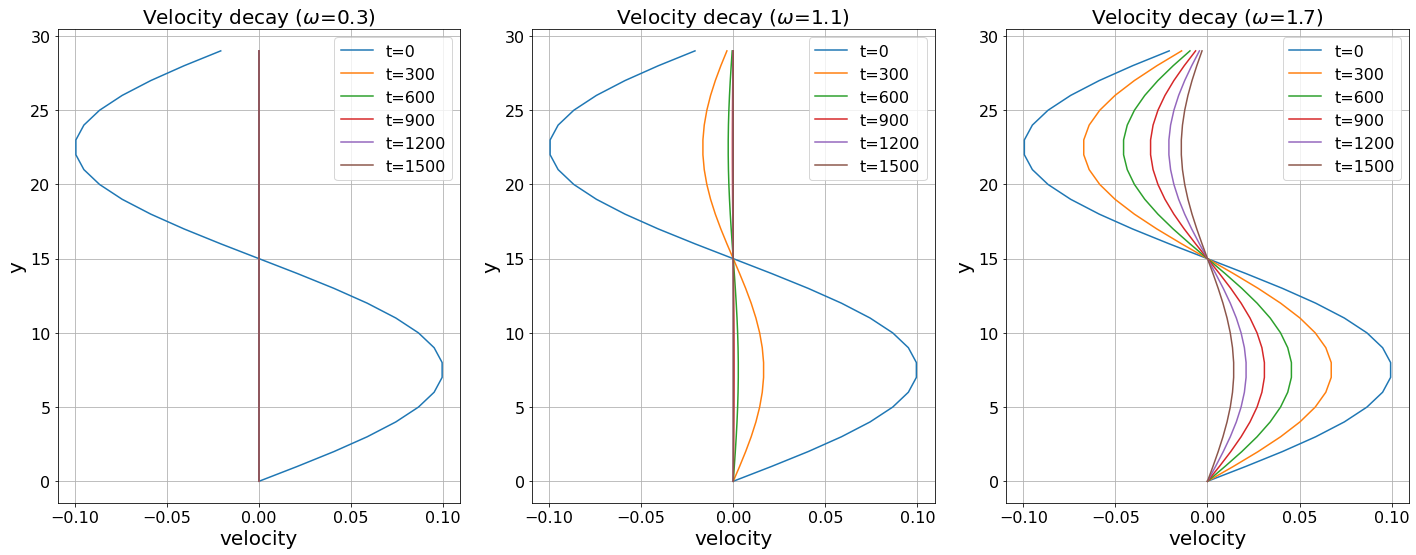

In [12]:
path_amps = './amps_total.npy'
path_vel = './velocities_print.npy'
if not isfile(path_amps) or not isfile(path_vel):
    m3.m3_2()

amps_total = np.load(path_amps, allow_pickle=True)
velocities_print = np.load(path_vel, allow_pickle=True)

fig, ax = plt.subplots(figsize=(20,8))
plt.axis('off')
axs = fig.subplots(nrows=1, ncols=3)
indices = [1,5,8]

for i, velocities, omega in zip(np.arange(3), velocities_print[indices], omegas[indices]):
    ax = axs[i]
    ax.set_title("Velocity decay ($\omega$={})".format(str(omega)))
    ax.set_xlabel("velocity")
    ax.set_ylabel("y")
    for t, v in enumerate(velocities[:6]): 
        ax.plot(v,np.arange(y_dim), label="t={}".format(t*300))
    ax.grid()
    ax.legend()
plt.tight_layout()
lbm.save_fig(fig, 'm3-2-velocity-decay.pgf')
plt.show()
plt.close()

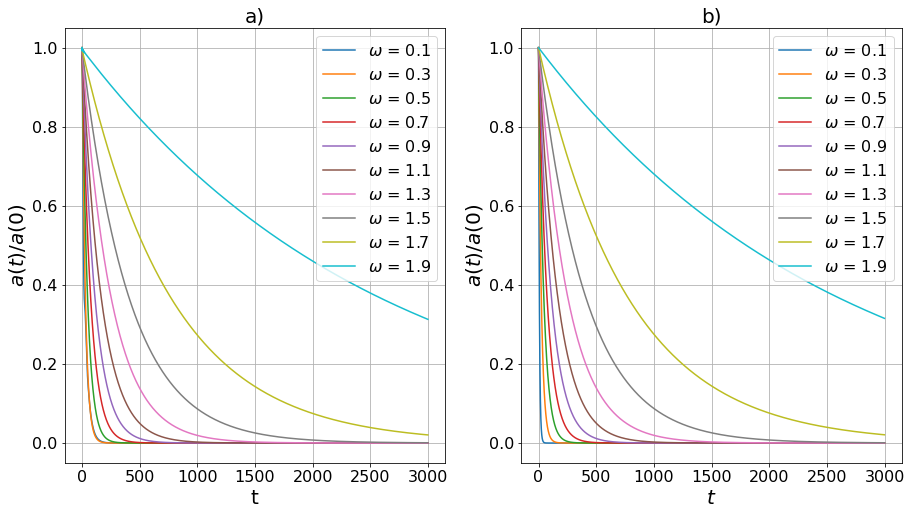

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
plt.axis('off')
axs = fig.subplots(nrows=1, ncols=2)

ax = axs[0]
for a,o in zip(amps_total,omegas):
    ax.plot(np.arange(epochs), a/a[0], label='$\omega$ = {}'.format(o))
# ax.set_title("Shear Wave Decay (empirical normalized amplitude)")
ax.set_xlabel('t')
ax.set_ylabel('$a(t)/a(0)$')
ax.set_title('a)')
ax.legend()
ax.grid()


ax = axs[1]
plots = []
for omega in omegas:
    amplitudes = []
    for e in range(epochs):
        nu = 1/3*(1/omega - 1/2)
        amp = np.exp(-nu*(2*np.pi/y_dim)**2*e)
        amplitudes.append(amp)
    plots.append([omega, amplitudes])
for p in plots:
    ax.plot(np.arange(epochs), p[1], label="$\omega$ = {}".format(p[0].round(1)))
# ax.set_title("Shear Wave Decay (theoretical normalized amplitude)")
ax.set_xlabel('$t$')
ax.set_ylabel('$a(t)/a(0)$')
ax.set_title('b)')
ax.legend()
ax.grid()
lbm.save_fig(fig, 'm3-2-shear-wave-decay.pgf')
plt.show()
plt.close()

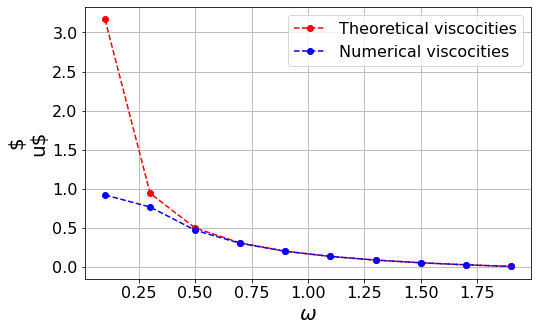

In [14]:
fig, ax = plt.subplots(figsize=(8,5))
nys_emp = []
for amp in amps_total:
    def func(x, a):
        return np.exp(-a*x*((2*np.pi/y_dim)**2))
    popt, pcov = curve_fit(func, np.arange(epochs), amp/amp[0])
    nys_emp.append(popt[0])
vs_theo = 1/3*(1/omegas-0.5)
ax.plot(omegas,vs_theo,'--ro', label='Theoretical viscocities')
ax.plot(omegas,nys_emp,'--bo', label='Numerical viscocities')
# ax.set_title("Kinematic viscosity scaling with  ω")
ax.set_xlabel('$\omega$')
ax.set_ylabel('$\nu$')
ax.legend()
ax.grid()
lbm.save_fig(fig, 'm3-3-kinematic-viscocity-scaling.pgf')
plt.show()
plt.close()

# Use bigger grid to get correct results

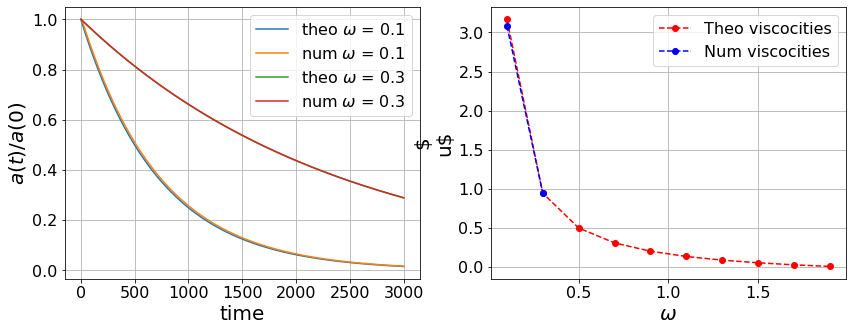

In [15]:
x_dim = 300
y_dim = 300
path_amps_updated = './amps_total_updated.npy'
path_vel_updated = './velocities_print_updated.npy'
if not isfile(path_amps_updated) or not isfile(path_vel_updated):
    m3.m3_2_updated()

amps_total = np.load(path_amps_updated)
velocities_print = np.load(path_vel_updated)

fig, ax = plt.subplots(figsize=(14,5))
plt.axis('off')
axs = fig.subplots(nrows=1, ncols=2)

ax = axs[0]
for a, o in zip(amps_total, omegas[:2]):
    amplitudes = []
    for e in range(epochs):
        nu = 1/3*(1/o - 1/2)
        amp = np.exp(-nu*(2*np.pi/y_dim)**2*e)
        amplitudes.append(amp)
    ax.plot(np.arange(epochs), amplitudes, label='theo $\omega$ = {}'.format(o))

    ax.plot(np.arange(epochs), a/a[0], label='num $\omega$ = {}'.format(o))

ax.set_xlabel('time')
ax.set_ylabel('$a(t)/a(0)$')
# ax.set_title('a)')
ax.legend()
ax.grid()

for omega in omegas[:2]:
    amplitudes = []
    for e in range(epochs):
        nu = 1/3*(1/omega - 1/2)
        amp = np.exp(-nu*(2*np.pi/y_dim)**2*e)
        amplitudes.append(amp)
    plots.append([omega, amplitudes])

ax = axs[1]
nys_emp = []
for amp in amps_total:
    def func(x, a):
        return np.exp(-a*x*((2*np.pi/y_dim)**2))
    popt, pcov = curve_fit(func, np.arange(epochs), amp/amp[0])
    nys_emp.append(popt[0])
vs_theo = 1/3*(1/omegas-0.5)
ax.plot(omegas,vs_theo,'--ro', label='Theo viscocities')
ax.plot(omegas[:2],nys_emp,'--bo', label='Num viscocities')
# ax.set_title("Kinematic viscosity scaling with  ω")
ax.set_xlabel('$\omega$')
ax.set_ylabel('$\nu$')
ax.legend()
ax.grid()
lbm.save_fig(fig, 'm3-3-update.pgf')
plt.show()
plt.close()

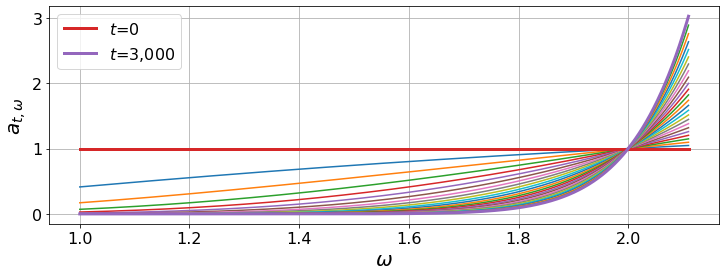

In [18]:
x_dim = 30
y_dim = 30

all = []
omegas = np.arange(1000)/900 + 1
for omega in omegas:
    amplitudes = []
    epos = np.arange(25)*121
    for e in epos:
        nu = 1/3*(1/omega - 1/2)
        amp = np.exp(-nu*(2*np.pi/y_dim)**2*e)
        amplitudes.append(amp.round(6))
    all.append(amplitudes)
all=np.array(all)

fig, ax = plt.subplots(figsize=(12,4))
# plt.axis('off')
for i in range(1,all.shape[1]-1):
    ax.plot(omegas, all[:,i])
ax.plot(omegas, all[:,0], label='$t$=0', linewidth=3)
ax.plot(omegas, all[:,-1], label='$t$=3,000', linewidth=3)

ax.set_xlabel('$\omega$')
ax.set_ylabel('$a_{t,\omega}$')
# ax.set_title('b)')
ax.legend()
ax.grid()
lbm.save_fig(fig, 'm3-4-increase.pgf')
plt.show()
plt.close()